## Import data

In [1]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 1058508 out of 2097150 valid rows.
Building 2 has 137790 out of 520938 valid rows.
Building 3 has 619925 out of 1942515 valid rows.


## Data preparation

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels
- Cumulative metrics probably won't be available when trying to predict future values
- `Louver_status` values are missing in building 3

In [2]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]
exclude_df3 = exclude + ["Louver_status"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude_df3)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [3]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    #df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

#import seaborn as sns
#sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

Remove rows with `NA` values for columns that do not have many `NA` values.

In [4]:
for df in dfs:
    # limit to columns with less than 5% NA values
    cutoff = len(df) // 20

    sums = df.isna().sum()
    sums = sums[sums != 0]
    #print(cutoff)
    #print(sums)
    sums = sums[sums <= cutoff]
    df.dropna(subset=sums.index, inplace=True)

We need to transform `Zone_name` from categorical to numeric. We'll use scikit-learn preprocessing to encode do this.

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import TargetEncoder

def encode(categorical_columns: list[int] | list[int]):
    return make_column_transformer((TargetEncoder(random_state=42), categorical_columns), remainder="passthrough")

#categorical_columns = ["Zone_name"]
#categorical_columns = ["Zone_name", "DOW"]
#df1 = pd.get_dummies(df1, columns=categorical_columns)
#dfs[0] = df1
#df2 = pd.get_dummies(df2, columns=categorical_columns)
#dfs[1] = df2
#df3 = pd.get_dummies(df3, columns=categorical_columns)
#dfs[2] = df3

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [6]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [7]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        train.drop(drop, inplace=True)

In [8]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Evaluating Model Performance

In [9]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.base import BaseEstimator

def calculate_metrics(model: BaseEstimator, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "f1": f1_score(y, y_predict, pos_label="On"),
        "ROC AUC": roc_auc_score(y, y_proba),
        "PR AUC": average_precision_score(y, y_proba, pos_label="On"),
        "Matthews": matthews_corrcoef(y, y_predict)
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

tree = DecisionTreeClassifier(random_state=42)
tree = make_pipeline(encode(["Zone_name"]), tree)
model_name = "Decision Tree"

### Building 1

In [11]:
tree.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9991    0.9996    0.9994     27615
          On     0.9999    0.9997    0.9998     76071

    accuracy                         0.9997    103686
   macro avg     0.9995    0.9996    0.9996    103686
weighted avg     0.9997    0.9997    0.9997    103686



### Building 2

In [12]:
tree.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9855    0.9616    0.9734     11577
          On     0.7778    0.9048    0.8365      1722

    accuracy                         0.9542     13299
   macro avg     0.8817    0.9332    0.9049     13299
weighted avg     0.9586    0.9542    0.9557     13299



### Building 3

In [13]:
tree.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9907    0.9897    0.9902     46202
          On     0.9683    0.9713    0.9698     15039

    accuracy                         0.9852     61241
   macro avg     0.9795    0.9805    0.9800     61241
weighted avg     0.9852    0.9852    0.9852     61241



## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

model_name = "Random Forest"
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest = make_pipeline(encode(["Zone_name"]), forest)


### Building 1

<Axes: >

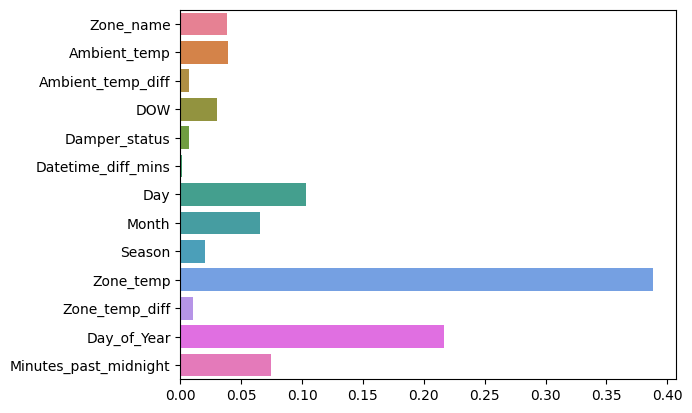

In [15]:
forest.fit(x_train1, y_train1)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [16]:
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9993    0.9999    0.9996     27615
          On     1.0000    0.9998    0.9999     76071

    accuracy                         0.9998    103686
   macro avg     0.9996    0.9998    0.9997    103686
weighted avg     0.9998    0.9998    0.9998    103686



### Building 2

<Axes: >

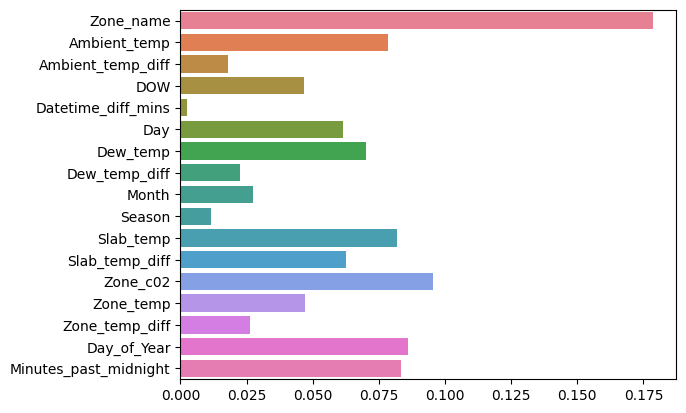

In [17]:
forest.fit(x_train2, y_train2)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [18]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9863    0.9776    0.9820     11577
          On     0.8580    0.9088    0.8827      1722

    accuracy                         0.9687     13299
   macro avg     0.9222    0.9432    0.9323     13299
weighted avg     0.9697    0.9687    0.9691     13299



### Building 3

<Axes: >

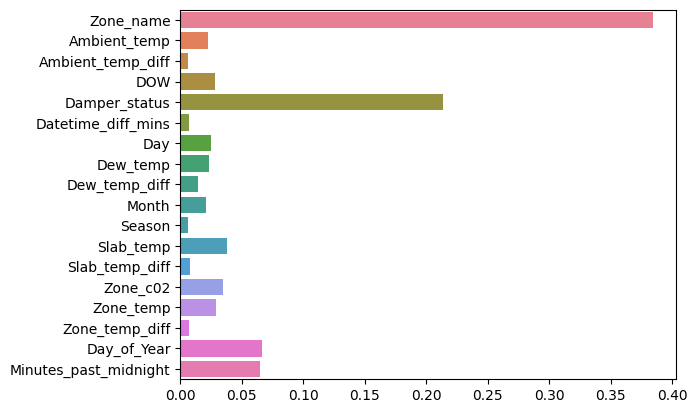

In [19]:
forest.fit(x_train3, y_train3)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [20]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9924    0.9962    0.9943     46202
          On     0.9881    0.9767    0.9823     15039

    accuracy                         0.9914     61241
   macro avg     0.9903    0.9864    0.9883     61241
weighted avg     0.9914    0.9914    0.9914     61241



## Histogram-based Gradient Boosting

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_name = "Hist Gradient Boosting"
histgb = HistGradientBoostingClassifier(random_state=42, categorical_features=["Zone_name"])

In [22]:
histgb.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(histgb, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9987    0.9942    0.9964     27615
          On     0.9979    0.9995    0.9987     76071

    accuracy                         0.9981    103686
   macro avg     0.9983    0.9969    0.9976    103686
weighted avg     0.9981    0.9981    0.9981    103686



In [23]:
histgb.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(histgb, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9711    0.9505    0.9607     11577
          On     0.7087    0.8095    0.7558      1722

    accuracy                         0.9323     13299
   macro avg     0.8399    0.8800    0.8582     13299
weighted avg     0.9371    0.9323    0.9341     13299



In [24]:
histgb.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(histgb, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9814    0.9884    0.9849     46202
          On     0.9635    0.9425    0.9529     15039

    accuracy                         0.9771     61241
   macro avg     0.9725    0.9654    0.9689     61241
weighted avg     0.9770    0.9771    0.9770     61241



## Logistic Regression

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
logit = LogisticRegression(random_state=42)
logit = make_pipeline(encode(["Zone_name"]), SimpleImputer(), StandardScaler(), logit)

In [26]:
logit.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(logit, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9894    0.4921    0.6573     27615
          On     0.8441    0.9981    0.9146     76071

    accuracy                         0.8633    103686
   macro avg     0.9167    0.7451    0.7860    103686
weighted avg     0.8828    0.8633    0.8461    103686



In [27]:
logit.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(logit, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9177    0.9258    0.9217     11577
          On     0.4698    0.4419    0.4554      1722

    accuracy                         0.8631     13299
   macro avg     0.6937    0.6839    0.6886     13299
weighted avg     0.8597    0.8631    0.8614     13299



In [28]:
logit.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(logit, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.8673    0.9374    0.9010     46202
          On     0.7443    0.5595    0.6388     15039

    accuracy                         0.8446     61241
   macro avg     0.8058    0.7485    0.7699     61241
weighted avg     0.8371    0.8446    0.8366     61241



## Model Performance
### Building 1

In [29]:
pd.DataFrame(model_metrics["Building 1"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.999662,0.999770,0.999643,0.999771,0.999136
Random Forest,0.999788,0.999855,0.999999,1.000000,0.999457
Hist Gradient Boosting,0.998100,0.998706,0.999981,0.999993,0.995136
Logistic Regression,0.863318,0.914638,0.806800,0.882285,0.639161


### Building 2

In [30]:
pd.DataFrame(model_metrics["Building 2"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.954207,0.836510,0.933162,0.716086,0.813190
Random Forest,0.968719,0.882685,0.990222,0.950311,0.865132
Hist Gradient Boosting,0.932251,0.755760,0.969057,0.853064,0.718769
Logistic Regression,0.863148,0.455416,0.820751,0.430898,0.377470


### Building 3

In [31]:
pd.DataFrame(model_metrics["Building 3"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.985157,0.969826,0.980498,0.947602,0.959986
Random Forest,0.991378,0.982343,0.999443,0.998210,0.976669
Hist Gradient Boosting,0.977107,0.952874,0.997478,0.992729,0.937857
Logistic Regression,0.844630,0.638831,0.907901,0.790183,0.551334


## Model Tuning

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

In [32]:
from mlmodel import SCORES
scores = list(SCORES)
tuned_metrics = {f"Building {n+1}": {} for n in range(3)}
save_folder = None

### Decision Tree

In [33]:
from mlmodel import GridSearchDecisionTree
model_name = "Decision Tree"
#save_folder = "output/decision_tree/analysis"
save_folder = None

#### Building 1

All parameters have been previously checked.


<Axes: xlabel='nodes'>

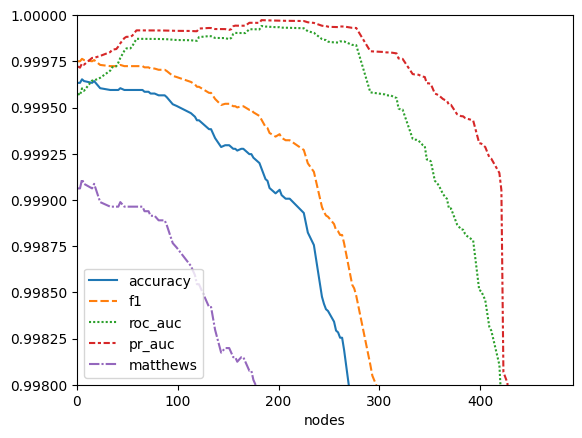

In [34]:
opt1 = GridSearchDecisionTree("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

df = opt1.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.998, 1.0)
display(plt)

In [35]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)

              precision    recall  f1-score   support

         Off     0.9991    0.9994    0.9992     27253
          On     0.9998    0.9997    0.9997     76433

    accuracy                         0.9996    103686
   macro avg     0.9994    0.9995    0.9995    103686
weighted avg     0.9996    0.9996    0.9996    103686



#### Building 2

All parameters have been previously checked.


<Axes: xlabel='nodes'>

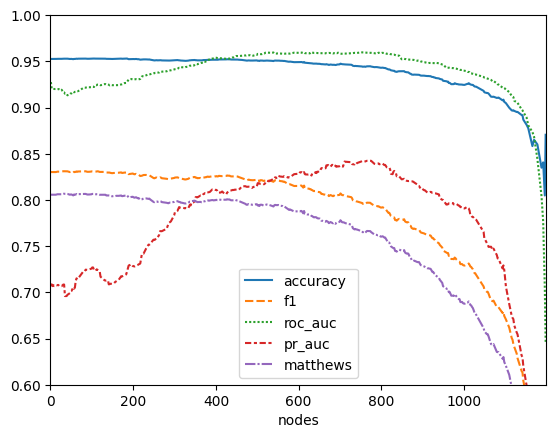

In [36]:
opt2 = GridSearchDecisionTree("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

df = opt2.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.6, 1.0)
display(plt)

In [37]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)

              precision    recall  f1-score   support

         Off     0.9835    0.9640    0.9737     11559
          On     0.7888    0.8926    0.8375      1741

    accuracy                         0.9547     13300
   macro avg     0.8862    0.9283    0.9056     13300
weighted avg     0.9580    0.9547    0.9558     13300



#### Building 3

All parameters have been previously checked.


<Axes: xlabel='nodes'>

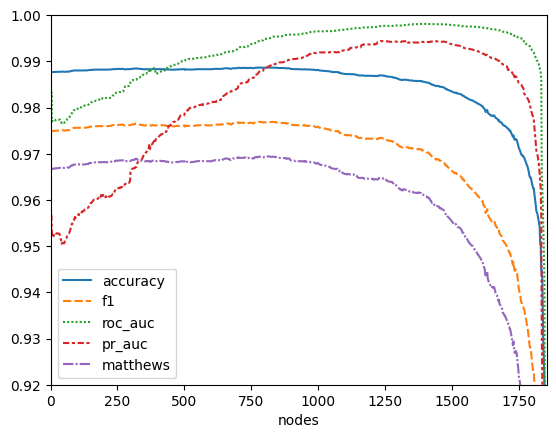

In [38]:
opt3 = GridSearchDecisionTree("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

df = opt3.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.92, 1.0)
display(plt)

In [39]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)

              precision    recall  f1-score   support

         Off     0.9920    0.9923    0.9922     46088
          On     0.9767    0.9756    0.9762     15153

    accuracy                         0.9882     61241
   macro avg     0.9843    0.9840    0.9842     61241
weighted avg     0.9882    0.9882    0.9882     61241



### Random Forest

In [40]:
from mlmodel import GridSearchRandomForest
model_name = "Random Forest"
#save_folder = "output/random_forest/analysis"
save_folder = None

#### Building 1

In [41]:
opt1 = GridSearchRandomForest("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

opt1.model[-1]

All parameters have been previously checked.


RandomForestClassifier(criterion='entropy', max_features=4, min_samples_split=9,
                       n_estimators=50, random_state=42)

<Axes: xlabel='min_samples_split'>

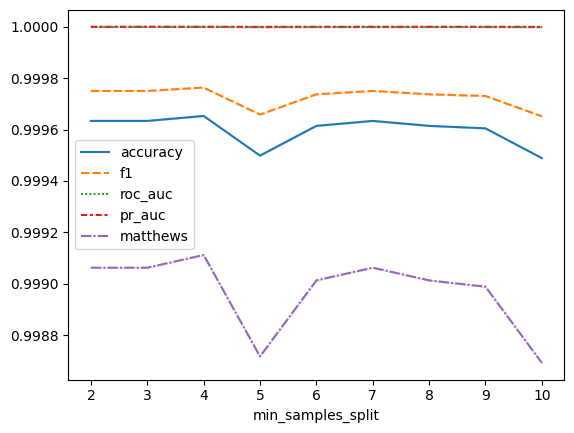

In [42]:
df = opt1.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
#plt.set_xlim(0, df.index.max())
#plt.set_ylim(0.98, 1.0)
display(plt)

In [43]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)

              precision    recall  f1-score   support

         Off     0.9997    0.9997    0.9997     27253
          On     0.9999    0.9999    0.9999     76433

    accuracy                         0.9999    103686
   macro avg     0.9998    0.9998    0.9998    103686
weighted avg     0.9999    0.9999    0.9999    103686



#### Building 2

In [44]:
opt2 = GridSearchRandomForest("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

opt2.model[-1]

All parameters have been previously checked.


RandomForestClassifier(criterion='entropy', max_features=9, n_estimators=50,
                       random_state=42)

<Axes: xlabel='min_samples_split'>

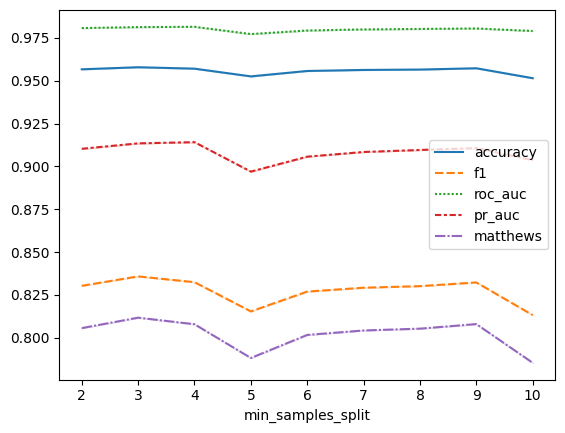

In [45]:
df = opt2.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [46]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)

              precision    recall  f1-score   support

         Off     0.9874    0.9802    0.9838     11559
          On     0.8745    0.9167    0.8951      1741

    accuracy                         0.9719     13300
   macro avg     0.9309    0.9485    0.9394     13300
weighted avg     0.9726    0.9719    0.9722     13300



In [47]:
opt3 = GridSearchRandomForest("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

opt3.model[-1]

All parameters have been previously checked.


RandomForestClassifier(criterion='entropy', max_features=9, n_estimators=300,
                       random_state=42)

<Axes: xlabel='min_samples_split'>

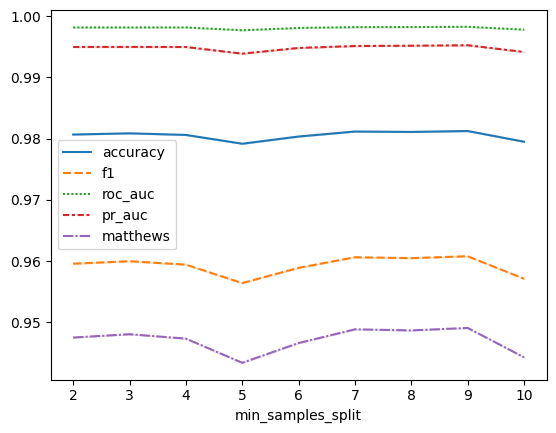

In [48]:
df = opt3.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [49]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)

              precision    recall  f1-score   support

         Off     0.9940    0.9959    0.9949     46088
          On     0.9873    0.9816    0.9844     15153

    accuracy                         0.9923     61241
   macro avg     0.9906    0.9887    0.9897     61241
weighted avg     0.9923    0.9923    0.9923     61241



## Tuned Model Performance
### Building 1

In [50]:
pd.DataFrame(tuned_metrics["Building 1"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.999605,0.999732,0.999555,0.999713,0.998980
Random Forest,0.999865,0.999908,1.000000,1.000000,0.999652


### Building 2

In [51]:
pd.DataFrame(tuned_metrics["Building 2"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.954662,0.837510,0.914526,0.709594,0.813374
Random Forest,0.971880,0.895121,0.991416,0.957984,0.879219


### Building 3

In [52]:
pd.DataFrame(tuned_metrics["Building 3"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.988211,0.976164,0.994498,0.986764,0.968333
Random Forest,0.992325,0.984446,0.999570,0.998807,0.979360
